Preprocessing

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2023-08-18 16:49:57.318195: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="/Users/QuangHoang/Documents/Potato_Disease/PlantVillage",
    batch_size= BATCH_SIZE,
    image_size= (IMAGE_SIZE, IMAGE_SIZE)
)

Found 2152 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

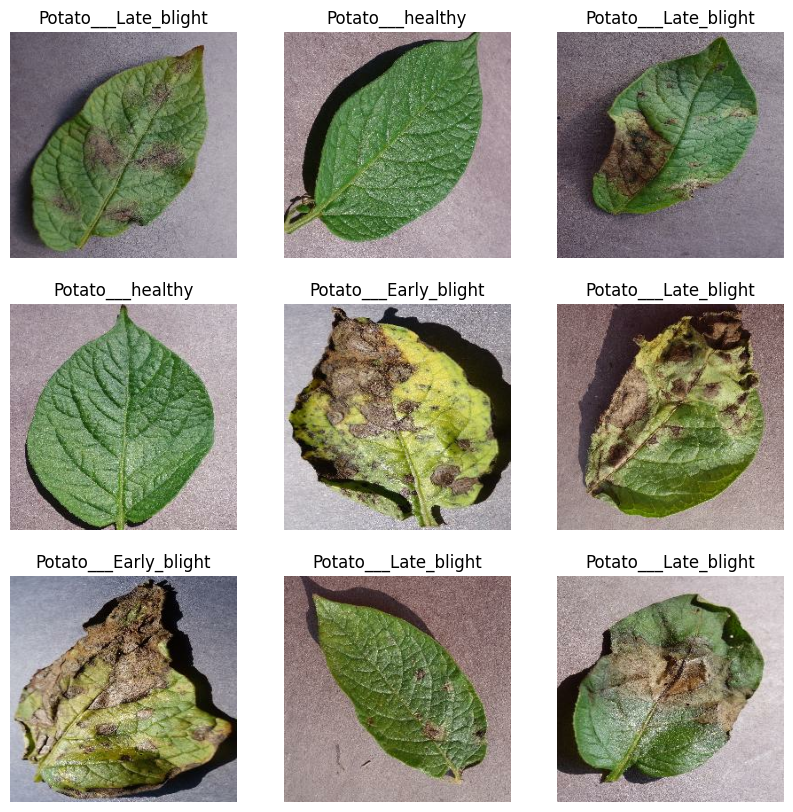

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis("off")

In [13]:
len(dataset) #=68 vi 32*68 = 2176

68

80% ==> training
20% ==> 10% validation, 10%test

In [17]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [18]:
train_ds = dataset.take(54) #lay 54 du lieu dau trong moi batch
len(train_ds)

54

In [19]:
test_ds = dataset.skip(54) #lay 68-54=14 du lieu con lai trong moi batch
len(test_ds)

14

In [6]:
#ham chia du lieu
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(ds_size * train_split)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)

    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
train_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Build model CNN

In [15]:
n_classes = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augumentation,
    layers.Conv2D(32, kernel_size = (3,3), activation="relu", input_shape =input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape = input_shape)

In [16]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 sequential_1 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [21]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

In [24]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
8/8 [==============================] - 11s 1s/step - loss: 0.2484 - accuracy: 0.8984 - val_loss: 0.2554 - val_accuracy: 0.8854
Epoch 2/50
8/8 [==============================] - 14s 2s/step - loss: 0.2669 - accuracy: 0.8789 - val_loss: 0.1841 - val_accuracy: 0.9271
Epoch 3/50
8/8 [==============================] - 12s 1s/step - loss: 0.1748 - accuracy: 0.9414 - val_loss: 0.2017 - val_accuracy: 0.9010
Epoch 4/50
8/8 [==============================] - 12s 1s/step - loss: 0.1559 - accuracy: 0.9375 - val_loss: 0.2216 - val_accuracy: 0.9271
Epoch 5/50
8/8 [==============================] - 12s 2s/step - loss: 0.1231 - accuracy: 0.9453 - val_loss: 0.1756 - val_accuracy: 0.9323
Epoch 6/50
8/8 [==============================] - 13s 2s/step - loss: 0.2189 - accuracy: 0.9219 - val_loss: 0.2406 - val_accuracy: 0.8854
Epoch 7/50
8/8 [==============================] - 11s 1s/step - loss: 0.1785 - accuracy: 0.9258 - val_loss: 0.5210 - val_accuracy: 0.8073
Epoch 8/50
8/8 [==================

In [26]:
scores =model.evaluate(test_ds)

8/8 [==============================] - 3s 273ms/step - loss: 0.2001 - accuracy: 0.9181


In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 8}

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training anf Validation Acc')

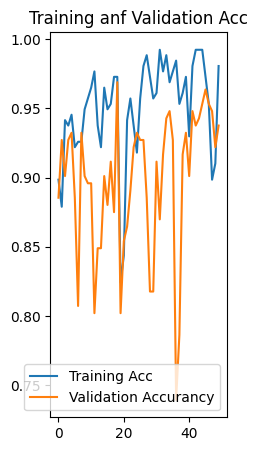

In [30]:
plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = "Training Acc")
plt.plot(range(EPOCHS), val_acc, label="Validation Accurancy")
plt.legend(loc ='lower right')
plt.title('Training anf Validation Acc')